In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

sns.set_style("whitegrid")


In [2]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (891, 12)
Test shape: (418, 11)


In [5]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.isnull().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


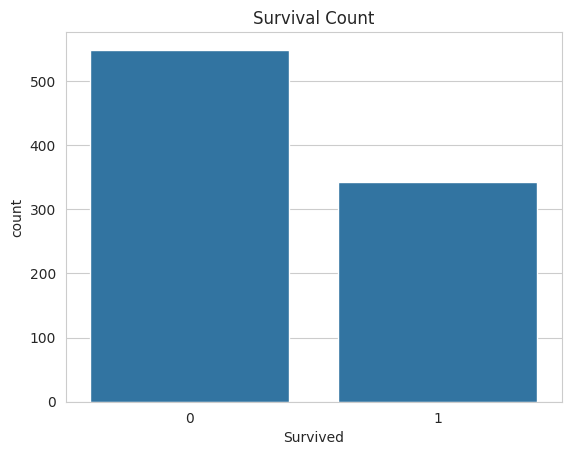

In [8]:
sns.countplot(x="Survived", data=train)
plt.title("Survival Count")
plt.show()


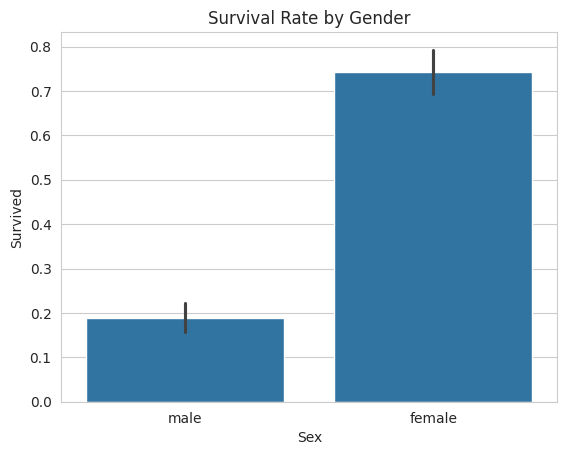

In [9]:
sns.barplot(x="Sex", y="Survived", data=train)
plt.title("Survival Rate by Gender")
plt.show()


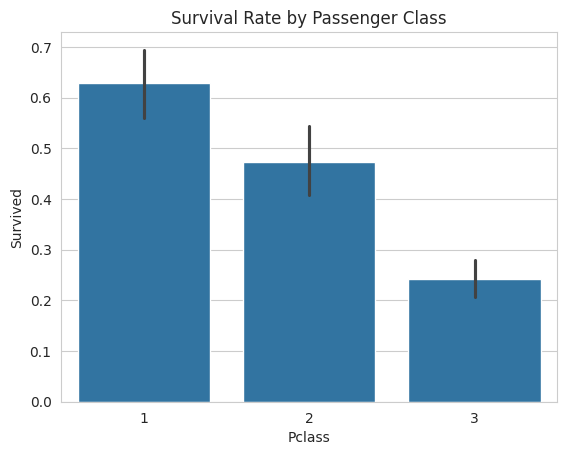

In [10]:
sns.barplot(x="Pclass", y="Survived", data=train)
plt.title("Survival Rate by Passenger Class")
plt.show()


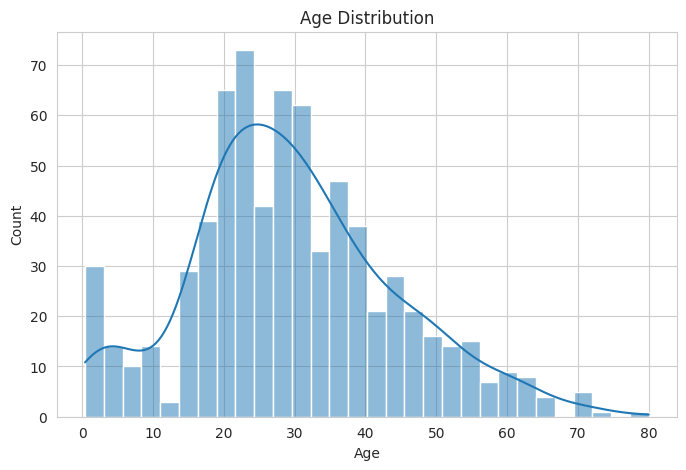

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(train["Age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()


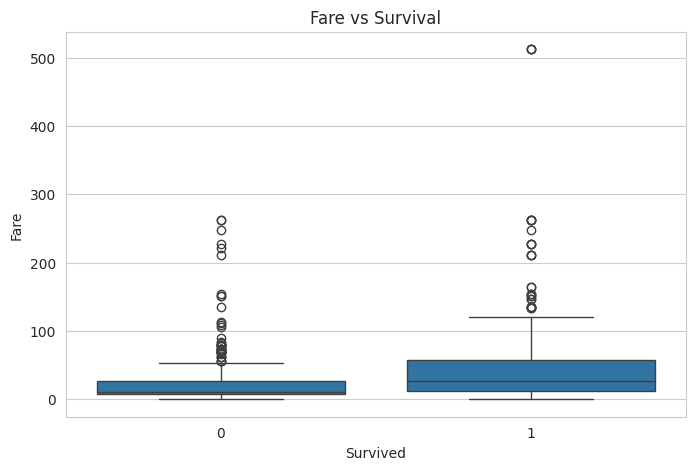

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Survived", y="Fare", data=train)
plt.title("Fare vs Survival")
plt.show()


In [13]:
# Family size
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

# Is Alone
train["IsAlone"] = (train["FamilySize"] == 1).astype(int)
test["IsAlone"] = (test["FamilySize"] == 1).astype(int)

# Title extraction
train["Title"] = train["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
test["Title"] = test["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

train["Title"].value_counts()


<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-2299836667.py:10: SyntaxWarning: invalid escape sequence '\.'
  train["Title"] = train["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
/tmp/ipython-input-2299836667.py:11: SyntaxWarning: invalid escape sequence '\.'
  test["Title"] = test["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)


,count
Title,
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Mlle,2
Major,2


In [14]:
common_titles = ["Mr", "Miss", "Mrs", "Master"]

train["Title"] = train["Title"].apply(lambda x: x if x in common_titles else "Other")
test["Title"] = test["Title"].apply(lambda x: x if x in common_titles else "Other")


In [15]:
features = [
    "Pclass", "Sex", "Age", "Fare",
    "Embarked", "FamilySize", "IsAlone", "Title"
]

X = train[features]
y = train["Survived"]
X_test = test[features]


In [16]:
num_features = ["Age", "Fare", "FamilySize"]
cat_features = ["Pclass", "Sex", "Embarked", "IsAlone", "Title"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])


In [17]:
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

voting_model = VotingClassifier(
    estimators=[
        ("lr", lr),
        ("rf", rf),
        ("gb", gb)
    ],
    voting="soft"
)


In [18]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", voting_model)
])


In [19]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation scores: [0.82122905 0.83146067 0.84269663 0.82022472 0.86516854]
Mean CV accuracy: 0.8361559224154165


In [20]:
model.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare',
                                                   'FamilySize']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'IsAlone', 'Title'])])),
                ('classifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=1000)),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=300,
                                                                      random_state=42)),
                                              ('gb',
                                               GradientBoostingClassifier(random_state=42))],
                                  voting='soft'))])

In [21]:
predictions = model.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})

submission.to_csv("titanic_submission.csv", index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
